In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import numpy as np
from scipy import stats
from tqdm import tqdm

from load_reviews import load_reviews

In [90]:
def f(x, a, b):
    return a * x + b

In [193]:
# Loading datasets
# ----------------
# I load it all
# I load it all
# I load it all
# And I load it now!

reviews_ba = load_reviews(path='../dataset/BeerAdvocate/reviews.txt', max_entries=None)
reviews_ba.dropna(subset=['overall', 'date'], inplace=True)
users_ba = pd.read_csv('../dataset/BeerAdvocate/users.csv')
beers_ba = pd.read_csv('../dataset/BeerAdvocate/beers.csv')

# Looking for americans and europeans
# -----------------------------------
# NOTE: For the moment, all non americans are tagged as europeans. This has to
# be improved.

users_ba.dropna(subset=['location'], inplace=True)
users_ba['continent'] = users_ba['location'].apply(lambda x: 'america' if x.startswith('United States') else 'europe')

# Merging reviews with beers
# --------------------------

detailed_reviews_ba = pd.merge(left=reviews_ba, right=beers_ba, on='beer_id', how='outer').copy()
detailed_reviews_ba = pd.merge(left=detailed_reviews_ba, right=users_ba, on='user_id', how='outer').copy()
detailed_reviews_ba.sort_values(by='date', inplace=True)

Loading reviews from ../dataset/BeerAdvocate/reviews.txt
Number of lines: 44022962


100%|██████████| 44022962/44022962 [00:28<00:00, 1561669.28it/s]


In [194]:
styles_name_ba = detailed_reviews_ba.groupby('style').count()['overall'].sort_values(ascending=False).index
styles_popularity_ba = detailed_reviews_ba.groupby('style').count()['overall'].sort_values(ascending=False).values

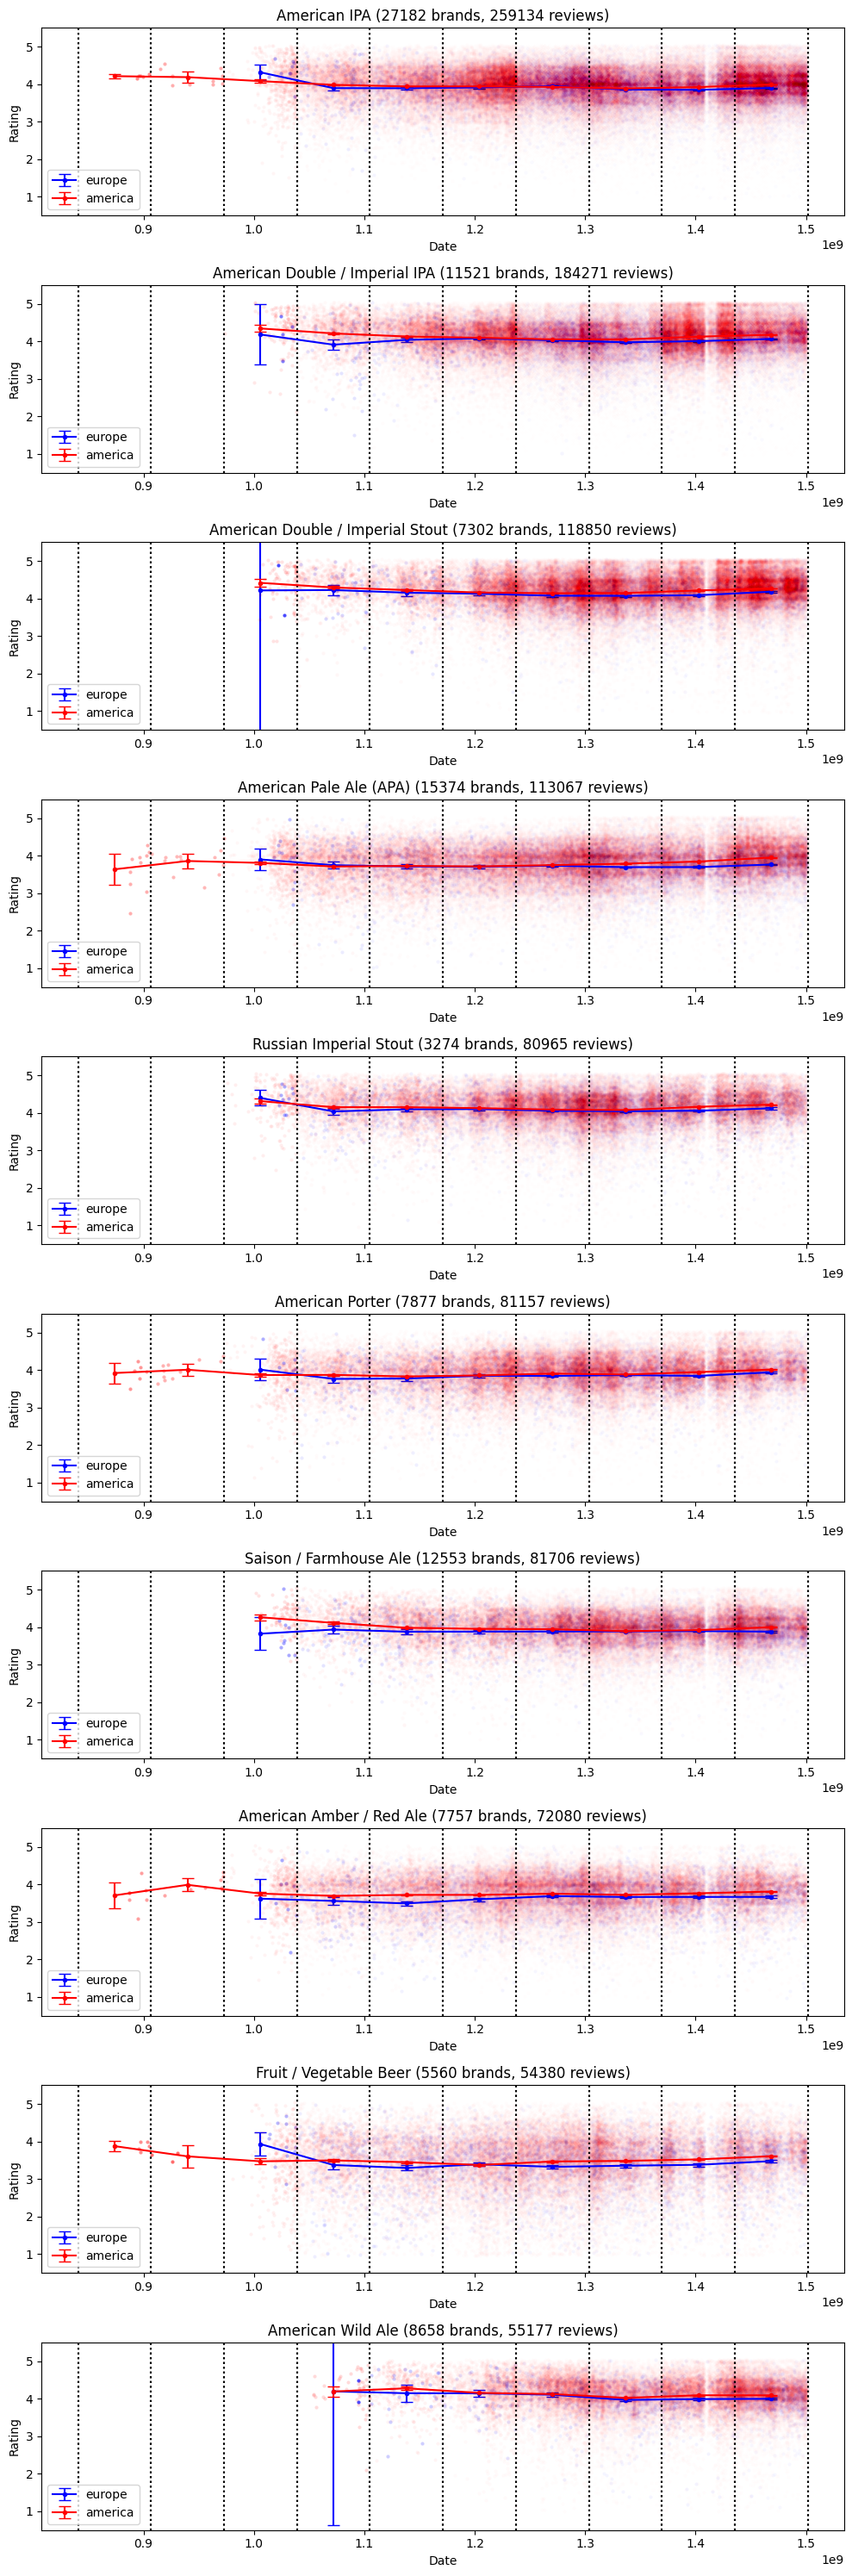

In [195]:
# Parameters
# ----------

STYLES_TO_PLOT = 10
BINNING = 10
CONFIDENCE_INTERVAL = 0.95

# Plotting
# --------

colors = {'europe': 'blue', 'america': 'red'}
markers = {'europe': '.', 'america': '.'}
binned_dates = np.linspace(detailed_reviews_ba['date'].min(), detailed_reviews_ba['date'].max(), BINNING + 1)

fig, axes = plt.subplots(figsize=(10, 3 * STYLES_TO_PLOT), ncols=1, nrows=STYLES_TO_PLOT)

for style_index, style_name in enumerate(styles_name_ba[:STYLES_TO_PLOT]):
    for continent in ['europe', 'america']:
        central_x = []
        mean_y = []
        confidence_intervals = []

        # Plotting individual ratings
        # ---------------------------

        for date1, date2 in zip(binned_dates[:-1], binned_dates[1:]):
            dummy = detailed_reviews_ba.query("style == @style_name & continent == @continent & date > @date1 & date < @date2")
            if len(dummy) <= 1:
                continue
            x = dummy['date'].values
            y = dummy['rating'].values
            y += np.random.uniform(3, 5, len(y))
            axes[style_index].plot(
                x,
                y,
                linestyle="none",
                marker=markers[continent],
                color=colors[continent],
                markeredgewidth=0, # NOTE: By default, every marker has an edge, which behaves strangely with alpha.
                alpha=1/len(dummy)**(1/2), # This formula seems to chose an ok alpha such that the plot remains readable. If needed, change the exponent.
            )

            central_x.append((date1 + date2) / 2)
            mean_y.append(np.mean(y))
            confidence_intervals.append(stats.t.ppf((1 + CONFIDENCE_INTERVAL) / 2, len(y)-1) * stats.sem(y))

        # Plotting means, confidence intervals, etc.
        # ------------------------------------------
        
        confidence_intervals = np.array(confidence_intervals)
        axes[style_index].errorbar(
            x=central_x,
            y=mean_y,
            yerr=np.array(confidence_intervals).T,
            linestyle="-",
            marker=".",
            color=colors[continent],
            label=continent,
            alpha=1,
            capsize=5,
        )
        for date in binned_dates:
            axes[style_index].axvline(date, linestyle=":", color="black", alpha=1)

    # Final polish
    # ------------

    reviews_count = len(detailed_reviews_ba.query("style == @style_name"))
    brands_count = len(beers_ba.query("style == @style_name")['beer_name'].unique())
    axes[style_index].set(
        xlabel='Date',
        ylabel='Rating',
        ylim=(0.5, 5.5),
        title=f'{style_name} ({brands_count} brands, {reviews_count} reviews)',
    )
    axes[style_index].legend(loc='lower left')
plt.tight_layout()
plt.show()